In [355]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [356]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [357]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 5 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    # mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y, side=mp.Low),
    mp.PML(tpml, direction=mp.Y, side=mp.High)
]

In [530]:
# 셀 크기 설정
# cell_size = mp.Vector3(Sx*3, Sy)
cell_size = mp.Vector3(width_bot_ag*3, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [531]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [532]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(width_bot_ag*3, 0)

dft_monitor = sims[0].add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

half_Sx, half_Sy = Sx/2, Sy/2
usable_h = Sy - 2*tpml                
monitor_width = width_bot_ag * 3      
half_Sx = width_bot_ag*3/2
n2f_regions = [
    mp.Near2FarRegion(
        center=mp.Vector3(-half_Sx+2/resolution, 0, 0),
        size=mp.Vector3(0, usable_h, 0),
        weight=-1
    ),
    mp.Near2FarRegion(
        center=mp.Vector3(+half_Sx-2/resolution, 0, 0),
        size=mp.Vector3(0, usable_h, 0),
        weight=+1
    ),
    mp.Near2FarRegion(
        center=mp.Vector3(0, -half_Sy+tpml, 0),
        size=mp.Vector3(monitor_width, 0, 0),
        weight=-1
    ),
    mp.Near2FarRegion(
        center=mp.Vector3(0, +half_Sy-tpml, 0),
        size=mp.Vector3(monitor_width, 0, 0),
        weight=+1
    )
]

# add_near2far 호출
n2f = sims[0].add_near2far(
    fcen,
    0,
    1,
    *n2f_regions,
)


In [533]:
design_load = np.loadtxt("SingleDipole_sum.txt")
design_variables.update_weights(design_load)

In [534]:
offset = 0.01
flux_size = 0.02
mn_size = 2

input_flux = sims[0].add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources[0].center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size),
                      weight=-1),
        mp.FluxRegion(center=sources[0].center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=sources[0].center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0),
                      weight=-1),
        mp.FluxRegion(center=sources[0].center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )

     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


<Axes: xlabel='X', ylabel='Y'>

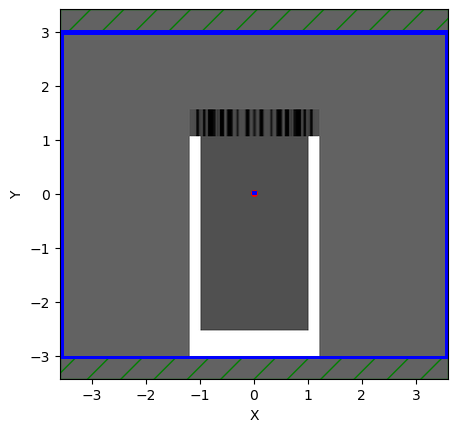

In [535]:
# 2) DFT 모니터: “직접 DFT” 방식으로 원거리 평면에서 Ez 측정
ff_distance = 1e8                      # far‑field 측정 거리
ff_angle    = 20                       # 최대 각도 (deg)
ff_npts     = 500                      # 샘플 포인트 수
ff_length   = ff_distance * math.tan(math.radians(ff_angle))
ff_res      = ff_npts / ff_length

# – 기존 near‑field DFT 모니터는 보존해두고…
monitor_position_J = mp.Vector3(0, center_y_monitor_position, 0)
monitor_width      = width_bot_ag * 3
dft_monitor        = sims[0].add_dft_fields(
    [mp.Ez], fcen, 0, 1,
    center=monitor_position_J,
    size=mp.Vector3(monitor_width, 0, 0),
    yee_grid=True
)


half_Sx = width_bot_ag*3/2
n2f_regions = [
    # 수직 방향 면 (X−, X+): 세로 크기만 usable_h
    mp.Near2FarRegion(
        center=mp.Vector3(-half_Sx+2/resolution, 0, 0),
        size=mp.Vector3(0, usable_h, 0),
        weight=-1
    ),
    mp.Near2FarRegion(
        center=mp.Vector3(+half_Sx-2/resolution, 0, 0),
        size=mp.Vector3(0, usable_h, 0),
        weight=+1
    ),

    # 수평 방향 면 (Y−, Y+): 가로 크기는 monitor_width, 세로 크기는 0
    mp.Near2FarRegion(
        center=mp.Vector3(0, -half_Sy+tpml, 0),
        size=mp.Vector3(monitor_width, 0, 0),
        weight=-1
    ),
    mp.Near2FarRegion(
        center=mp.Vector3(0, +half_Sy-tpml, 0),
        size=mp.Vector3(monitor_width, 0, 0),
        weight=+1
    )
]
n2f = sims[0].add_near2far(fcen, df, nfreq, *n2f_regions,
                           nperiods=3, decimation_factor=0)
sims[0].plot2D()


In [536]:
mp.verbosity(1)
sim = sims[0]
sim.run(until_after_sources=mp.stop_when_fields_decayed(
    10/df, mp.Ez, sources[0].center, 1e-3
))

Ez_dft = sim.get_dft_array(dft_monitor, mp.Ez, 0)   
I_dft  = np.abs(Ez_dft)**2
x_dft  = np.linspace(-monitor_width/2, monitor_width/2, I_dft.size)

ff_distance = 20
ff_angle    = 90

ff_length = monitor_width
ff_res    = ff_npts / ff_length

far_data = sim.get_farfields(
    n2f,
    resolution=ff_res,
    center=mp.Vector3(0, ff_distance, 0),
    size=mp.Vector3(ff_length, 0, 0)
)
Ez_n2f = far_data['Ez']
if Ez_n2f.ndim > 1:
    Ez_n2f = Ez_n2f[:, 0]
I_n2f = np.abs(Ez_n2f)**2
x_n2f = np.linspace(-ff_length/2, ff_length/2, I_n2f.size)

-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.86 x 0 with resolution 50
     block, center = (0,-2.775,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.525,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (-1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.525,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.325,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0898421 s
lorentzian susceptibility: frequency=16.365, gamma

In [563]:
0.19/mp.get_fluxes(input_flux)[0]

0.47838826243352617

In [516]:
r     = 10  # µm
npts  = 360    # 샘플링 각도 개수
angles = np.linspace(0, 2*np.pi, npts, endpoint=False)

FF = np.zeros(npts)

for i, theta in enumerate(angles):
    pt = mp.Vector3(r * math.cos(theta),
                    r * math.sin(theta),
                    0)
    ff = sims[0].get_farfield(n2f, pt)  
    E  = np.array(ff[:3])               
    FF[i] = np.sum(np.abs(E)**2)        

FF_norm = FF / FF.max()

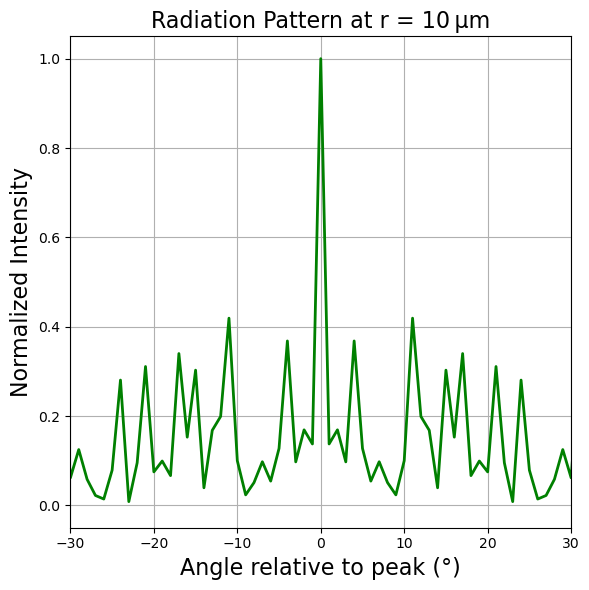

In [517]:
# 1) 각도(도) 변환
angles_deg = np.degrees(angles)  # 0 ~ 360

# 2) 최대 방사 세기의 각도 찾기
peak_idx   = np.argmax(FF_norm)
peak_angle = angles_deg[peak_idx]

# 3) peak_angle을 0°로 shift & [-180,180] 범위로 래핑
shifted = (angles_deg - 90 + 180) % 360 - 180

# 4) x축 오름차순 정렬
order         = np.argsort(shifted)
shifted_sorted = shifted[order]
FF_sorted      = FF_norm[order]

# 5) Cartesian plot
plt.figure(figsize=(6,6))
plt.plot(shifted_sorted, FF_sorted, 'g-',linewidth=2)
plt.xlabel("Angle relative to peak (°)", fontsize=fontlabel)
plt.ylabel("Normalized Intensity",     fontsize=fontlabel)
plt.title("Radiation Pattern at r = 10 µm", fontsize=fontlabel)
plt.grid(True)
plt.xlim(-30, 30)
plt.tight_layout()
plt.show()


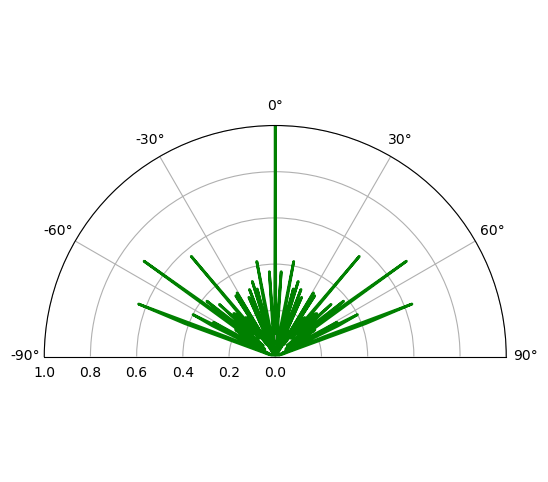

In [518]:
angles_rad = np.deg2rad(shifted_sorted)              # shifted_sorted: –180°~+180°
mask       = np.abs(shifted_sorted) <= 90            # |θ|≤90°  
angles_plot = angles_rad[mask]
FF_plot     = FF_sorted[mask]

# ——— 2) Polar plot ———
plt.figure(figsize=(6,6))
ax = plt.subplot(projection='polar')

ax.plot(angles_plot, FF_plot,'g-', linewidth=2)
ax.set_theta_zero_location("N")      # 0°를 위쪽(North)으로
ax.set_theta_direction(-1)           # 시계 방향으로 증가
ax.set_thetamin(-90)                 # 최소 각도
ax.set_thetamax(90)                  # 최대 각도
ax.set_rlim(0, 1)

plt.show()

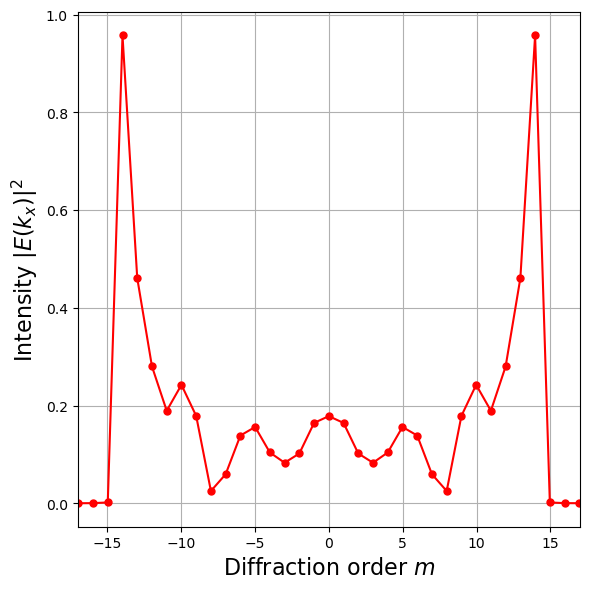

In [519]:
kx      = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))

Lambda = width_bot_ag*3
m      = kx * Lambda / (2*np.pi)

E_k = np.fft.fftshift(np.fft.fft(Ez_dft)) * dx
I_k = np.abs(E_k)**2

plt.figure(figsize=(6,6))
plt.plot(m, I_k, 'ro-', markersize=5)
plt.xlabel(r"Diffraction order $m$", fontsize=16)
plt.ylabel(r"Intensity $|E(k_x)|^2$",    fontsize=16)
plt.xlim(-17, 17)   # 보고 싶은 차수 범위
plt.grid(True)
plt.tight_layout()
plt.show()


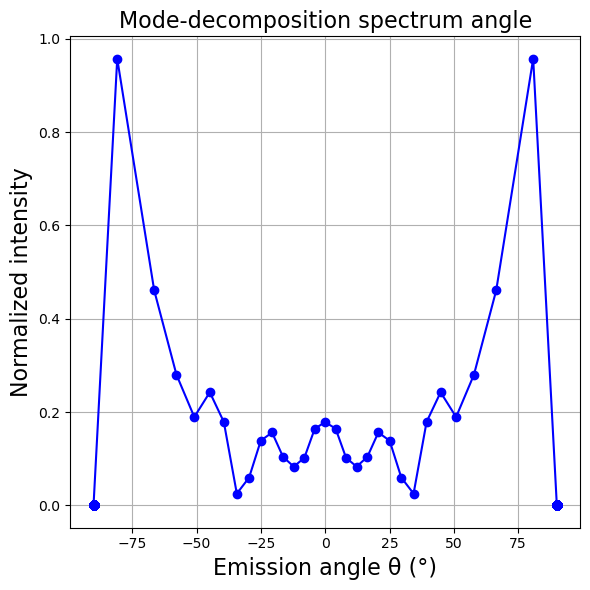

In [524]:
import numpy as np
import matplotlib.pyplot as plt

# near‑field DFT 결과
Ez_line = sim.get_dft_array(dft_monitor, mp.Ez, 0)  # E_z(x)
N       = len(Ez_line)
dx      = 1.0 / resolution

# FFT → kx, intensity
E_k = np.fft.fftshift(np.fft.fft(Ez_line)) * dx
I_k = np.abs(E_k)**2

# Angle 변환 
kx  = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * 2*np.pi  # rad/μm
k0         = 2 * np.pi * fcen
ratio      = kx / k0
ratio_clip = np.clip(ratio, -1.0, 1.0)
theta_deg  = np.degrees(np.arcsin(ratio_clip))  # 각도 단위

# 정규화 & 플롯
I_norm = I_k / I_k.max()

plt.figure(figsize=(6,6))
plt.plot(theta_deg, I_k, 'bo-')
plt.xlabel('Emission angle θ (°)', fontsize=16)
plt.ylabel('Normalized intensity',   fontsize=16)
plt.title('Mode‑decomposition spectrum angle', fontsize=16)

# plt.xlim(-30, 30)
plt.grid(True)
plt.tight_layout()
plt.show()


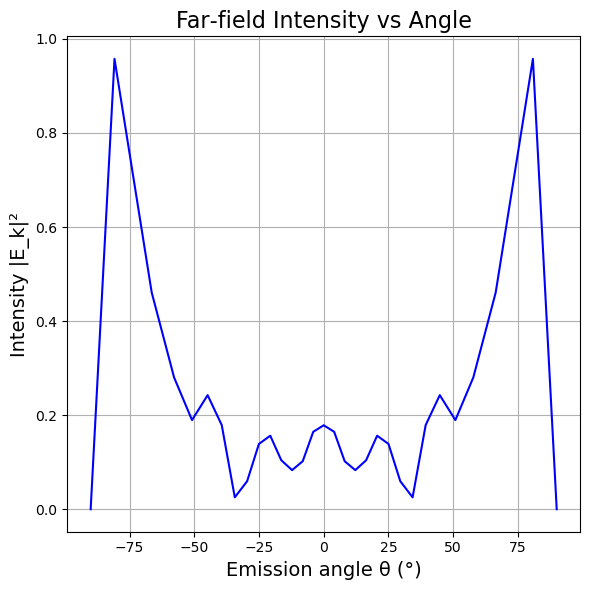

In [549]:
import numpy as np
import matplotlib.pyplot as plt

# 1) near‑field Ez_line (shape = N,)
Ez_line = sim.get_dft_array(dft_monitor, mp.Ez, 0)

# 2) FFT → kx, intensity
N  = len(Ez_line)
dx = 1.0/resolution        # μm 단위 그리드 간격
E_k = np.fft.fftshift(np.fft.fft(Ez_line)) * dx
I_k = np.abs(E_k)**2       # far‑field intensity

# 3) kx 계산
#    np.fft.fftfreq 에서 반환되는 단위는 “사이클 per μm” 이므로, 2π를 곱해 “rad/μm” 로 변환
kx = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * 2*np.pi  # rad/μm

# 4) 입사파 벡터 k0
k0 = 2 * np.pi * fcen      # fcen 단위가 GHz라면 fcen*1e9 로 Hz 변환 필요

# 5) 각도 계산 (rad → deg)
#    |kx/k0|>1 인 경우 nan 이 되므로, clip 으로 [-1,1] 제한
ratio      = kx / k0
ratio_clip = np.clip(ratio, -1.0, 1.0)
theta_deg  = np.degrees(np.arcsin(ratio_clip))  # ° 단위

# 6) 플롯: x축을 각도로
plt.figure(figsize=(6,6))
plt.plot(theta_deg, I_k, 'b-')
plt.xlabel('Emission angle θ (°)', fontsize=14)
plt.ylabel('Intensity |E_k|²', fontsize=14)
plt.title('Far‑field Intensity vs Angle', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


±45° 구간 통합 강도: 1.104746e+01


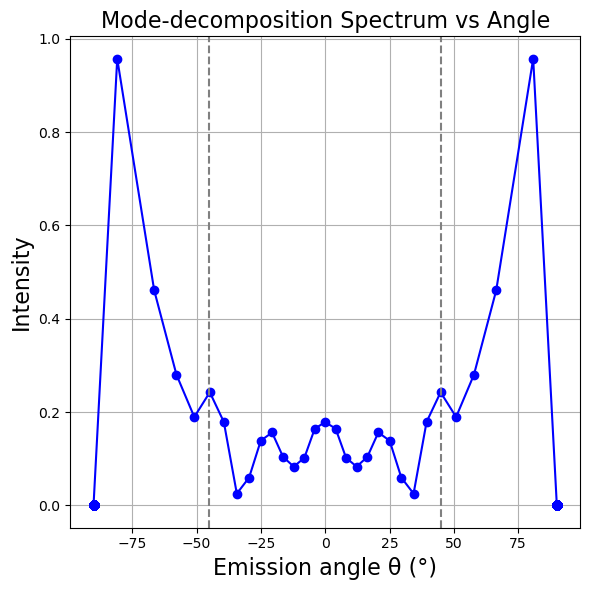

In [557]:
import numpy as np
import matplotlib.pyplot as plt

# near‑field DFT 결과
Ez_line = sim.get_dft_array(dft_monitor, mp.Ez, 0)  # E_z(x)
N       = len(Ez_line)
dx      = 1.0 / resolution

# FFT → kx, intensity
E_k = np.fft.fftshift(np.fft.fft(Ez_line)) * dx
I_k = np.abs(E_k)**2

# Angle 변환 
kx  = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * 2*np.pi  # rad/μm
k0         = 2 * np.pi * fcen
ratio      = kx / k0
ratio_clip = np.clip(ratio, -1.0, 1.0)
theta_deg  = np.degrees(np.arcsin(ratio_clip))  # 각도 단위

# ±45° 구간 강도 적분
mask = (theta_deg >= -45) & (theta_deg <= 45)
theta_sel = theta_deg[mask]
I_sel     = I_k[mask]
I_integrated = np.trapz(I_sel, theta_sel)
print(f'±45° 구간 통합 강도: {I_integrated:e}')

# 플롯
plt.figure(figsize=(6,6))
plt.plot(theta_deg, I_k, 'bo-', linewidth=1.5)
plt.axvline(+45, color='gray', linestyle='--')
plt.axvline(-45, color='gray', linestyle='--')
plt.xlabel('Emission angle θ (°)', fontsize=16)
plt.ylabel('Intensity',          fontsize=16)
plt.title('Mode‑decomposition Spectrum vs Angle', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


첫 번째 로브 경계 각도: ±16.38° (인덱스 184)
로브 1차 경계(±16.38°)까지 통합 강도: 3.722177e+00


/tmp/ipykernel_542369/294733275.py:63: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/294733275.py:63: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/294733275.py:63: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/294733275.py:63: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/294733275.py:63: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/294733275.py:63: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/294733275.py:63: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from font(s) DejaVu Sans.
  pl

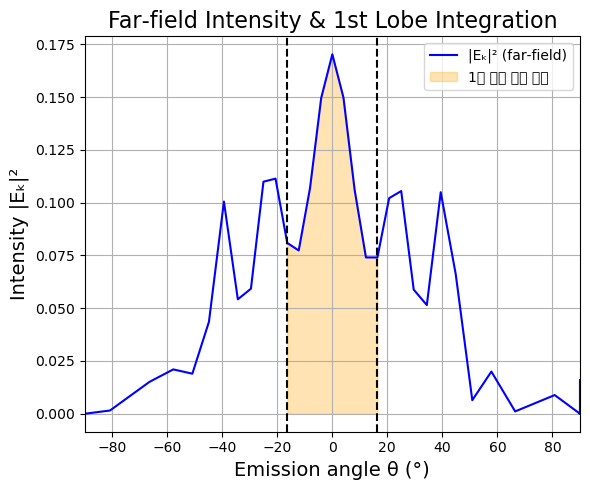

In [562]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) far‑field 계산 (FFT → θ, I_k) ---
Ez_line = sim.get_dft_array(dft_monitor, mp.Ez, 0)  # near‑field E_z(x)
N       = len(Ez_line)
dx      = 1.0/resolution      # μm 단위
# optional: 윈도우를 씌워 링잉 완화
window = np.hanning(N)
Ez_win = Ez_line * window

# FFT → far‑field 스펙트럼
E_k = np.fft.fftshift(np.fft.fft(Ez_win)) * dx
I_k = np.real(E_k)**2           # 크기 제곱

# kx, θ 계산
kx       = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * 2*np.pi  # rad/μm
k0       = 2*np.pi * fcen     # fcen [1/μm] 가정 (rad/μm)
theta    = np.degrees(np.arcsin(np.clip(kx/k0, -1, 1)))  # °

#  정렬
idx      = np.argsort(theta)
theta_s  = theta[idx]
I_s      = I_k[idx]

# --- 2) 중심 인덱스 찾기 (θ≈0에 가장 가까운 지점) ---
center_idx = np.argmin(np.abs(theta_s))

# --- 3) 중심 이후 첫 번째 국소 최소점 찾기(로브 경계) ---
minima_idx = None
for j in range(center_idx+1, len(theta_s)-1):
    if I_s[j] < I_s[j-1] and I_s[j] < I_s[j+1]:
        minima_idx = j
        break

if minima_idx is None:
    raise RuntimeError("첫 번째 로브 경계(minimum)를 찾지 못했습니다.")

# 경계 각도
theta_edge = abs(theta_s[minima_idx])
print(f"첫 번째 로브 경계 각도: ±{theta_edge:.2f}° (인덱스 {minima_idx})")

# --- 4) 그 범위까지 적분 ---
mask = (np.abs(theta_s) <= theta_edge)
I_integrated = np.trapz(I_s[mask], theta_s[mask])
print(f'로브 1차 경계(±{theta_edge:.2f}°)까지 통합 강도: {I_integrated:.6e}')

# --- 5) 결과 시각화 ---
plt.figure(figsize=(6,5))
plt.plot(theta_s, I_s,   'b-', lw=1.5, label='|Eₖ|² (far‑field)')
plt.fill_between(theta_s, I_s, where=mask,
                 color='orange', alpha=0.3, label='1차 로브 적분 영역')
# 경계선 표시
plt.axvline(+theta_edge, color='k', ls='--')
plt.axvline(-theta_edge, color='k', ls='--')

plt.xlim(-90, 90)
plt.xlabel('Emission angle θ (°)', fontsize=14)
plt.ylabel('Intensity |Eₖ|²', fontsize=14)
plt.title('Far‑field Intensity & 1st Lobe Integration', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


±45° 구간 통합 강도: 0.000e+00


/tmp/ipykernel_542369/1065062773.py:51: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/1065062773.py:51: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/1065062773.py:51: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_542369/1065062773.py:51: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


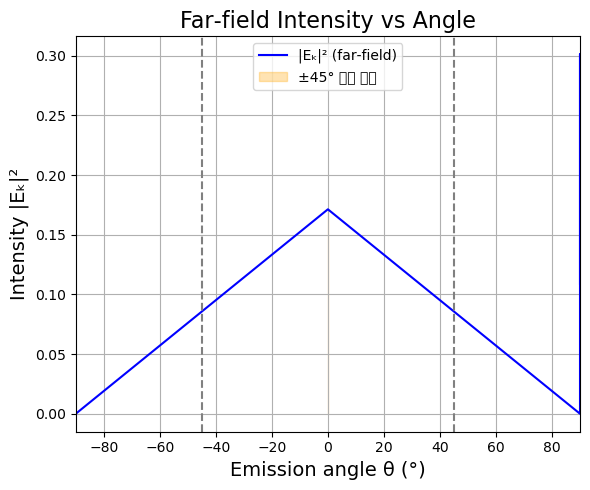

In [556]:
import numpy as np
import matplotlib.pyplot as plt

# 1) near‑field Ez_line (shape = N,)
Ez_line = sim.get_dft_array(dft_monitor, mp.Ez, 0)

# 2) 물리 단위
N  = len(Ez_line)
dx = 1.0 / resolution        # μm 단위 그리드 간격
c0 = 3e8                     # m/s

# 3) 윈도우 적용 (스펙트럴 링잉 방지)
window = np.hanning(N)
Ez_win = Ez_line * window

# 4) FFT → kx, intensity (magnitude²)
E_k = np.fft.fftshift(np.fft.fft(Ez_win)) * dx
I_k = np.abs(E_k)**2      # ★ 복소 크기 제곱

# 5) kx, θ 계산
#   fftfreq 의 단위는 사이클/μm → rad/μm 로 변환
kx = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * 2*np.pi  # rad/μm
# k0 = 2π·(fcen / c) 단위를 μm⁻¹ 로 바꾸려면 fcen [Hz], c[m/s] → c_μm/s = c0/1e6
k0 = 2*np.pi * fcen / (c0/1e6)    # rad/μm
theta_deg = np.degrees(np.arcsin(np.clip(kx/k0, -1, 1)))  # °

# 6) θ 순서대로 정렬
idx      = np.argsort(theta_deg)
theta_s  = theta_deg[idx]
I_s      = I_k[idx]

# 7) ±45° 구간 적분
mask45        = (theta_s >= -45) & (theta_s <= 45)
theta_45      = theta_s[mask45]
I_45          = I_s[mask45]
I_integrated  = np.trapz(I_45, theta_45)
print(f'±45° 구간 통합 강도: {I_integrated:.3e}')

# 8) 플롯
plt.figure(figsize=(6,5))
plt.plot(theta_s, I_s, 'b-', lw=1.5, label='|Eₖ|² (far‑field)')
plt.fill_between(theta_45, I_45, color='orange', alpha=0.3, label='±45° 적분 영역')
plt.axvline(+45, color='gray', ls='--')
plt.axvline(-45, color='gray', ls='--')
plt.xlim(-90, 90)
plt.xlabel('Emission angle θ (°)', fontsize=14)
plt.ylabel('Intensity |Eₖ|²', fontsize=14)
plt.title('Far‑field Intensity vs Angle', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


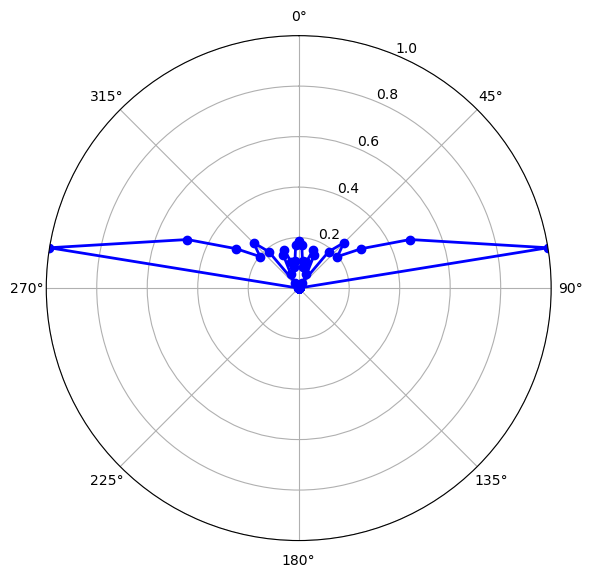

In [521]:
import numpy as np
import matplotlib.pyplot as plt

# — (이미 계산된 데이터) —
# theta_deg : Emission angle θ in degrees (배열)
# I_norm    : Normalized intensity (배열, 0…1)

# 1) 각도를 라디안으로 변환
theta_rad = np.radians(theta_deg)

# 2) polar plot 그리기
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection='polar')

# θ=0°를 위쪽으로, 시계 방향으로 증가시키려면:
ax.set_theta_zero_location('N')     # 'N': 위쪽이 0°
ax.set_theta_direction(-1)          # -1: 시계 방향 양수 증가

# 데이터 플롯
ax.plot(theta_rad, I_norm, 'bo-', linewidth=2)

# 축 레이블/타이틀
# ax.set_title('Far‑field Radiation Patter
# n (Polar)', va='bottom')

# 반경(r) 범위 0…1 고정
ax.set_rlim(0, 1)

plt.tight_layout()
plt.show()


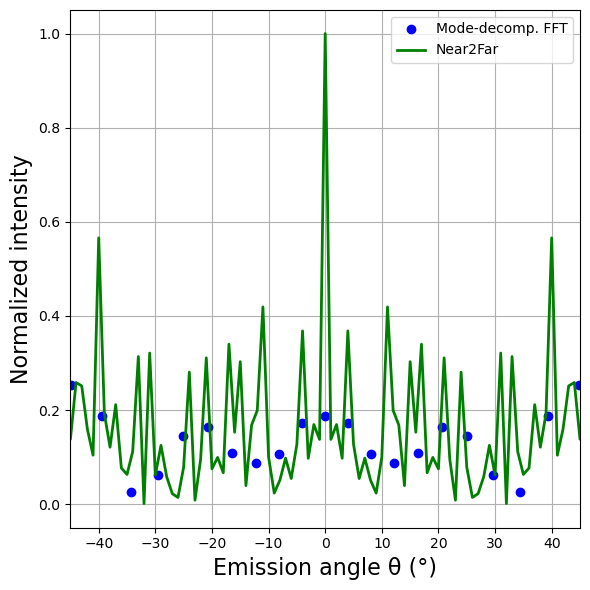

In [522]:
import numpy as np
import matplotlib.pyplot as plt

# ───────────────────────────────────────────────────────────────
# 1) Mode‑decomposition spectrum → angle & intensity
Ez_line = sim.get_dft_array(dft_monitor, mp.Ez, 0)  # near‑field E_z(x)
N       = len(Ez_line)
dx      = 1.0 / resolution

# FFT → kx, I_k
E_k   = np.fft.fftshift(np.fft.fft(Ez_line)) * dx
I_k   = np.abs(E_k)**2
kx    = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * 2*np.pi  # rad/μm

# kx → emission angle θ
k0         = 2 * np.pi * fcen
ratio      = kx / k0
theta_deg  = np.degrees(np.arcsin(np.clip(ratio, -1, 1)))    # °

# normalize
I_fft_norm = I_k / I_k.max()


angles_deg    = np.degrees(angles)  # convert to degrees 0…360
shifted       = (angles_deg - peak_angle)  # shift so peak at 0°
shifted       = (shifted + 90) % 360 - 180  # wrap to [-180,180]
order         = np.argsort(shifted)
shifted_sorted = shifted[order]
FF_sorted      = FF_norm

# 1) 각도(도) 변환
angles_deg = np.degrees(angles)  # 0 ~ 360

# 2) 최대 방사 세기의 각도 찾기
peak_idx   = np.argmax(FF_norm)
peak_angle = angles_deg[peak_idx]

# 3) peak_angle을 0°로 shift & [-180,180] 범위로 래핑
shifted = (angles_deg - 90 + 180) % 360 - 180

# 4) x축 오름차순 정렬
order         = np.argsort(shifted)
shifted_sorted = shifted[order]
FF_sorted      = FF_norm[order]
# ───────────────────────────────────────────────────────────────
# 3) Overlay plot
plt.figure(figsize=(6,6))

# mode‑decomposition spectrum
plt.plot(theta_deg, I_fft_norm, 'bo', label='Mode‑decomp. FFT')

# near2far radiation pattern
plt.plot(shifted_sorted, FF_sorted, 'g-', linewidth=2, label='Near2Far')

plt.xlabel('Emission angle θ (°)', fontsize=fontlabel)
plt.ylabel('Normalized intensity',     fontsize=fontlabel)
plt.xlim(-45, 45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

